#1 Setup/Initialization

## 1.1 Import Libraries

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from google.colab import drive

In [2]:
# Initialization
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## 1.2 Import Datasets

In [3]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
col_names = ["ZONEID", "TIMESTAMP", "tclw (kg/m**2)", "tciw (kg/m**2)",
             "SP (Pa)", "r (%)", "TCC (0-1)", "10u (m/s)", "10v (m/s)",
             "2T (K)", "SSRD (J/m**2)", "STRD (J/m**2)", "TSR (J/m**2)",
             "TP (m)", "POWER"]
train_df = pd.read_csv("/content/drive/MyDrive/CS 458 Data Mining/Solar Power Generation Forecast/solar_training.csv",
                          header=0, names=col_names)
test_df = pd.read_csv("/content/drive/MyDrive/CS 458 Data Mining/Solar Power Generation Forecast/solar_test.csv",
                      header=0, names=col_names)
test_df.dropna(inplace=True)

In [5]:
train_df.head(3)

,ZONEID,TIMESTAMP,tclw (kg/m**2),tciw (kg/m**2),SP (Pa),r (%),TCC (0-1),10u (m/s),10v (m/s),2T (K),SSRD (J/m**2),STRD (J/m**2),TSR (J/m**2),TP (m),POWER
0,1,20120401 01:00,0.001967,0.003609,94843.6250,60.221909,0.244601,1.039334,-2.503039,294.448486,2577830.0,1202532.0,2861797.0,0.000000,0.754103
1,1,20120401 02:00,0.005524,0.033575,94757.9375,54.678604,0.457138,2.482865,-2.993330,295.651367,5356093.0,2446757.0,5949378.0,0.000000,0.555000
2,1,20120401 03:00,0.030113,0.132009,94732.8125,61.294891,0.771429,3.339867,-1.982535,294.454590,7921788.0,3681336.0,8939176.0,0.001341,0.438397


In [6]:
test_df.head(3)

,ZONEID,TIMESTAMP,tclw (kg/m**2),tciw (kg/m**2),SP (Pa),r (%),TCC (0-1),10u (m/s),10v (m/s),2T (K),SSRD (J/m**2),STRD (J/m**2),TSR (J/m**2),TP (m),POWER
0,1.0,20130701 01:00,0.001335,0.0,95342.6875,74.118164,0.048920,1.131939,-0.579174,282.172363,1557786.0,955170.625,1733948.0,0.0,0.123846
1,1.0,20130701 02:00,0.000179,0.0,95259.6875,67.015564,0.005646,1.716605,-0.476846,284.574219,3380267.0,1906639.000,3728032.0,0.0,0.194103
2,1.0,20130701 03:00,0.000267,0.0,95166.3125,59.357101,0.000000,2.750459,-0.378750,286.135742,5244430.0,2872777.000,5764803.0,0.0,0.511474


## 1.3 Prepare Dataframes
Save the indices for each zone separately. Remove columns which are not of datatype float64 from dataframes. This is to allow direct use of the dataframes in the TensorFlow models as tensors. Save removed columns separately.

In [7]:
train_df.columns

Index(['ZONEID', 'TIMESTAMP', 'tclw (kg/m**2)', 'tciw (kg/m**2)', 'SP (Pa)',
       'r (%)', 'TCC (0-1)', '10u (m/s)', '10v (m/s)', '2T (K)',
       'SSRD (J/m**2)', 'STRD (J/m**2)', 'TSR (J/m**2)', 'TP (m)', 'POWER'],
      dtype='object')

In [8]:
train1_index = train_df.query("ZONEID == 1").index
train2_index = train_df.query("ZONEID == 2").index
train3_index = train_df.query("ZONEID == 3").index

test1_index = test_df.query("ZONEID == 1").index
test2_index = test_df.query("ZONEID == 2").index
test3_index = test_df.query("ZONEID == 3").index

In [9]:
train_zoneid = train_df.pop("ZONEID")
train_timestamp = pd.to_datetime(train_df.pop("TIMESTAMP"), format="%Y%m%d %H:%M")
train_df.dtypes

tclw (kg/m**2)    float64
tciw (kg/m**2)    float64
SP (Pa)           float64
r (%)             float64
TCC (0-1)         float64
10u (m/s)         float64
10v (m/s)         float64
2T (K)            float64
SSRD (J/m**2)     float64
STRD (J/m**2)     float64
TSR (J/m**2)      float64
TP (m)            float64
POWER             float64
dtype: object

In [10]:
test_zoneid = test_df.pop("ZONEID").astype("int64")
test_timestamp = pd.to_datetime(test_df.pop("TIMESTAMP"), format="%Y%m%d %H:%M")
test_df.dtypes

tclw (kg/m**2)    float64
tciw (kg/m**2)    float64
SP (Pa)           float64
r (%)             float64
TCC (0-1)         float64
10u (m/s)         float64
10v (m/s)         float64
2T (K)            float64
SSRD (J/m**2)     float64
STRD (J/m**2)     float64
TSR (J/m**2)      float64
TP (m)            float64
POWER             float64
dtype: object

In [11]:
try:
    tf.convert_to_tensor(train_df)
    tf.convert_to_tensor(test_df)
    print("Success!")
except Exception as e:
    raise e

Success!


In [12]:
train_df.head(3)

,tclw (kg/m**2),tciw (kg/m**2),SP (Pa),r (%),TCC (0-1),10u (m/s),10v (m/s),2T (K),SSRD (J/m**2),STRD (J/m**2),TSR (J/m**2),TP (m),POWER
0,0.001967,0.003609,94843.6250,60.221909,0.244601,1.039334,-2.503039,294.448486,2577830.0,1202532.0,2861797.0,0.000000,0.754103
1,0.005524,0.033575,94757.9375,54.678604,0.457138,2.482865,-2.993330,295.651367,5356093.0,2446757.0,5949378.0,0.000000,0.555000
2,0.030113,0.132009,94732.8125,61.294891,0.771429,3.339867,-1.982535,294.454590,7921788.0,3681336.0,8939176.0,0.001341,0.438397


In [13]:
test_df.head(3)

,tclw (kg/m**2),tciw (kg/m**2),SP (Pa),r (%),TCC (0-1),10u (m/s),10v (m/s),2T (K),SSRD (J/m**2),STRD (J/m**2),TSR (J/m**2),TP (m),POWER
0,0.001335,0.0,95342.6875,74.118164,0.048920,1.131939,-0.579174,282.172363,1557786.0,955170.625,1733948.0,0.0,0.123846
1,0.000179,0.0,95259.6875,67.015564,0.005646,1.716605,-0.476846,284.574219,3380267.0,1906639.000,3728032.0,0.0,0.194103
2,0.000267,0.0,95166.3125,59.357101,0.000000,2.750459,-0.378750,286.135742,5244430.0,2872777.000,5764803.0,0.0,0.511474


# 2 Preprocessing Data

## 2.1 Inspection of Data

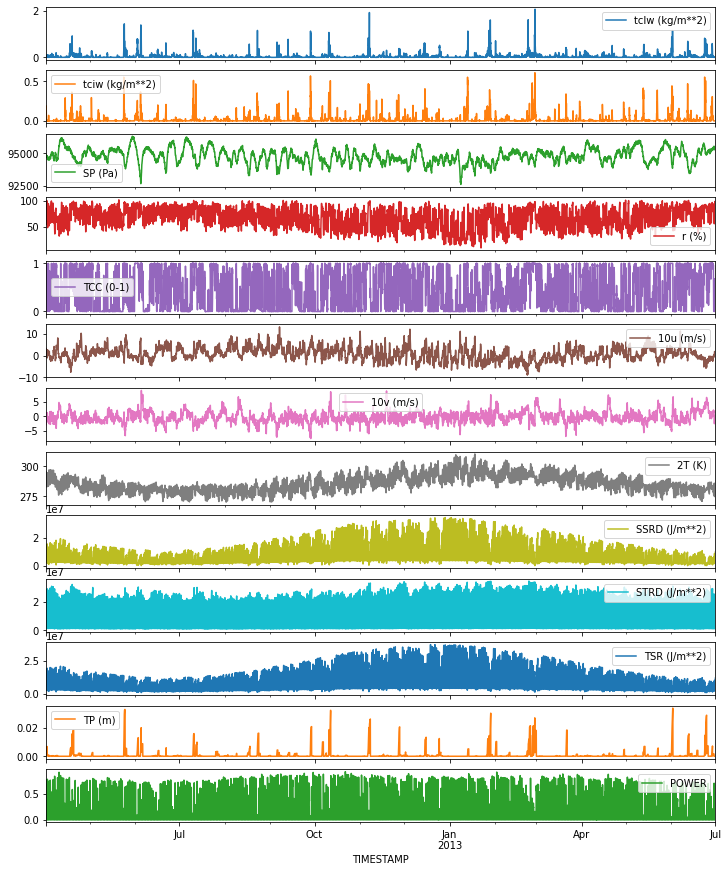

In [14]:
# Over entire duration
df = train_df.iloc[train1_index]
df.index = train_timestamp.iloc[train1_index]
_ = df.plot(subplots=True, figsize=(12,15))

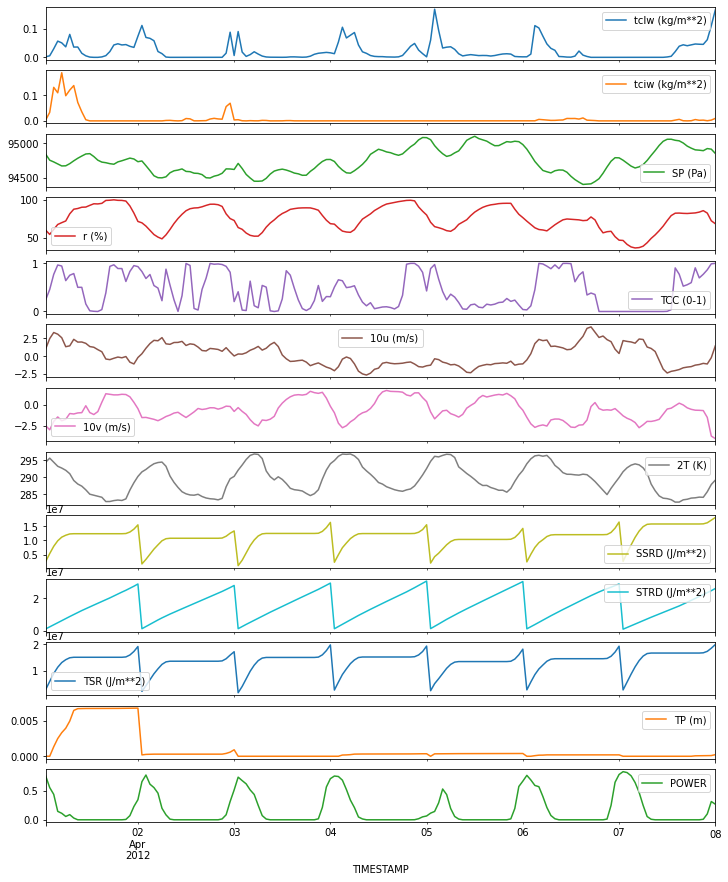

In [15]:
# Over first week
df = train_df.iloc[train1_index[:24*7]]
df.index = train_timestamp.iloc[train1_index[:24*7]]
_ = df.plot(subplots=True, figsize=(12,15))

In [16]:
# Summary statistics
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
tclw (kg/m**2),32832.0,3.972925e-02,1.133595e-01,0.000000,0.000000e+00,2.702713e-03,3.370478e-02,2.068974e+00
tciw (kg/m**2),32832.0,1.569156e-02,4.872373e-02,0.000000,0.000000e+00,9.970000e-05,6.114316e-03,6.066458e-01
SP (Pa),32832.0,9.385919e+04,1.094945e+03,90359.000000,9.294675e+04,9.406238e+04,9.470189e+04,9.630806e+04
r (%),32832.0,6.854489e+01,1.971381e+01,8.525364,5.376610e+01,7.149540e+01,8.534492e+01,1.017909e+02
TCC (0-1),32832.0,4.227350e-01,3.970266e-01,0.000000,1.000977e-02,3.221868e-01,8.605469e-01,1.000008e+00
10u (m/s),32832.0,6.842536e-01,2.403277e+00,-8.908603,-7.597842e-01,3.517013e-01,2.064232e+00,1.305672e+01
10v (m/s),32832.0,-1.048489e-01,2.073906e+00,-8.404230,-1.521249e+00,-2.937789e-01,1.137790e+00,1.071100e+01
2T (K),32832.0,2.846813e+02,7.063519e+00,269.596435,2.793439e+02,2.838306e+02,2.893610e+02,3.100623e+02
SSRD (J/m**2),32832.0,1.186076e+07,6.388731e+06,149878.000000,7.156000e+06,1.054804e+07,1.634618e+07,3.442611e+07
STRD (J/m**2),32832.0,1.367547e+07,7.671840e+06,823598.187500,7.214234e+06,1.353454e+07,1.979196e+07,3.417538e+07


## 2.2 Cleanup of Data
Represent time of day and time of year as signals.

In [17]:
day = 24*60*60
year = (365.2425)*day

train_timestamp_s = train_timestamp.map(pd.Timestamp.timestamp)
test_timestamp_s = test_timestamp.map(pd.Timestamp.timestamp)

train_df["Day sin"] = np.sin(train_timestamp_s * (2 * np.pi / day))
train_df["Day cos"] = np.cos(train_timestamp_s * (2 * np.pi / day))
train_df["Year sin"] = np.sin(train_timestamp_s * (2 * np.pi / year))
train_df["Year cos"] = np.cos(train_timestamp_s * (2 * np.pi / year))

test_df["Day sin"] = np.sin(test_timestamp_s * (2 * np.pi / day))
test_df["Day cos"] = np.cos(test_timestamp_s * (2 * np.pi / day))
test_df["Year sin"] = np.sin(test_timestamp_s * (2 * np.pi / year))
test_df["Year cos"] = np.cos(test_timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

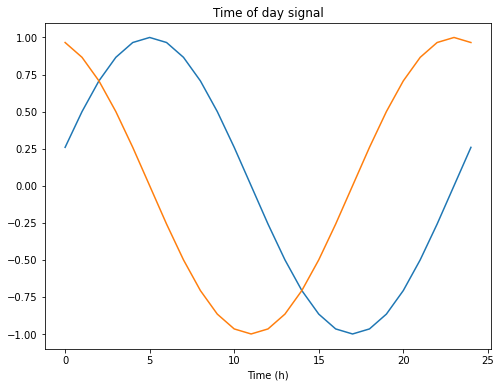

In [18]:
plt.plot(np.array(train_df["Day sin"])[:25])
plt.plot(np.array(train_df["Day cos"])[:25])
plt.xlabel("Time (h)")
plt.title("Time of day signal")

Text(0.5, 1.0, 'Time of year signal')

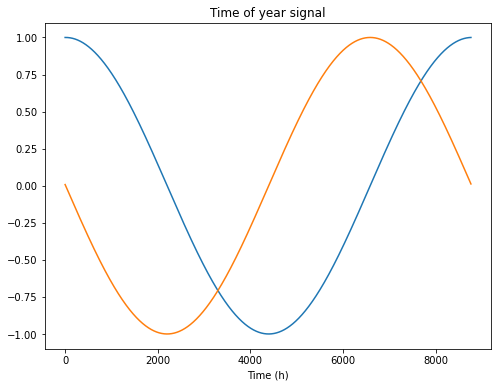

In [19]:
plt.plot(np.array(train_df["Year sin"])[:365*24 + 1])
plt.plot(np.array(train_df["Year cos"])[:365*24 + 1])
plt.xlabel("Time (h)")
plt.title("Time of year signal")

## 2.3 Split the Data
Split training data 80:20 for training and validation set, respectively.

In [20]:
column_index = {name: i for i, name in enumerate(train_df.columns)}

n_train1 = len(train1_index)
train1_df = train_df.loc[train1_index[0:int(n_train1*0.8)]]
val1_df = train_df.loc[train1_index[int(n_train1*0.8):]]
test1_df = test_df.loc[test1_index]

n_train2 = len(train2_index)
train2_df = train_df.loc[train2_index[0:int(n_train2*0.8)]]
val2_df = train_df.loc[train2_index[int(n_train2*0.8):]]
test2_df = test_df.loc[test2_index]

n_train3 = len(train3_index)
train3_df = train_df.loc[train3_index[0:int(n_train3*0.8)]]
val3_df = train_df.loc[train3_index[int(n_train3*0.8):]]
test3_df = test_df.loc[test3_index]

num_features = train_df.shape[1]

## 2.4 Normalize the Data

In [21]:
train1_mean = train1_df.mean()
train1_std = train1_df.std()
train1_df = (train1_df - train1_mean) / train1_std
val1_df = (val1_df - train1_mean) / train1_std
test1_df = (test1_df - train1_mean) / train1_std

train2_mean = train2_df.mean()
train2_std = train2_df.std()
train2_df = (train2_df - train2_mean) / train2_std
val2_df = (val2_df - train2_mean) / train2_std
test2_df = (test2_df - train2_mean) / train2_std

train3_mean = train3_df.mean()
train3_std = train3_df.std()
train3_df = (train3_df - train3_mean) / train3_std
val3_df = (val3_df - train3_mean) / train3_std
test3_df = (test3_df - train3_mean) / train3_std

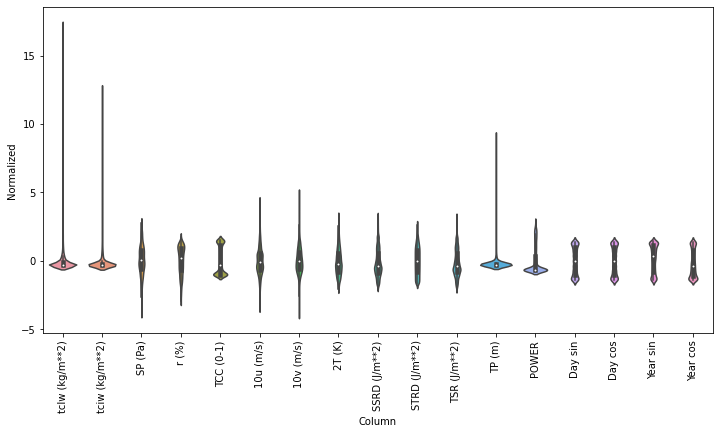

In [22]:
# Distribution of features for training data at zone 1
df_std = (train_df.loc[train1_index] - train1_mean) / train1_std
df_std = df_std.melt(var_name="Column", value_name="Normalized")
plt.figure(figsize=(12,6))
ax = sns.violinplot(x="Column", y="Normalized", data=df_std)
_ = ax.set_xticklabels(train_df.keys(), rotation=90)

# 3 Data Windowing
We want to make predictions based on a window of consecutive samples from the data. Specifically, we want to make a single prediction for "POWER" 24 hours into the future, given 24 hours of history.

To do this for all our models, a `WindowGenerator` class is implemented as follows. This class is designed to accomodate for both:
* Single-output and multi-output predictions.
* Single-time-step and multi-time-step predictions.

In [23]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df, val_df, test_df,
                 label_columns=None):
        # Store the raw data
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                          enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}
        
        # Work out the window parameters
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def __repr__(self):
        return "\n".join([
            f"Total window size: {self.total_window_size}",
            f"Input indices: {self.input_indices}",
            f"Label indices: {self.label_indices}",
            f"Label column name(s): {self.label_columns}"])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)
        
        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col="POWER", max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12,8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f"{plot_col} [normed]")
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label="Inputs", marker=".", zorder=-10)
            
            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index
            
            if label_col_index is None:
                continue
            
            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors="k", label="Labels", c="#2ca02c", s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices,
                            predictions[n, :, label_col_index],
                            marker="X", edgecolors="k", label="Predictions",
                            c="#ff7f0e", s=64)
            
            if n == 0:
                plt.legend()
        
        plt.xlabel("Time [h]")

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)
        ds = ds.map(self.split_window)

        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def example(self):
        # Get and cache an example batch of `inputs, labels` for plotting
        result = getattr(self, "_example", None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

# 4 Models

In [24]:
# Results of models
val_performance1 = {}
performance1 = {}
val_performance2 = {}
performance2 = {}
val_performance3 = {}
performance3 = {}

In [33]:
# Windows for each zone
OUT_STEPS = 24 # no. of hours into the future

w1 = WindowGenerator(input_width=24, label_width=OUT_STEPS, shift=OUT_STEPS,
                    train_df=train1_df, val_df=val1_df, test_df=test1_df)

w2 = WindowGenerator(input_width=24, label_width=OUT_STEPS, shift=OUT_STEPS,
                    train_df=train2_df, val_df=val2_df, test_df=test2_df)

w3 = WindowGenerator(input_width=24, label_width=OUT_STEPS, shift=OUT_STEPS,
                    train_df=train3_df, val_df=val3_df, test_df=test3_df)

In [26]:
# Training procedure function
MAX_EPOCHS = 20
def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                      patience=patience,
                                                      mode="min")
    
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])
    
    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

## 4.1 Baseline
This model acts as a performance baseline for comparison with other models. This baseline model simply returns the current power as the prediction.

### 4.1.1 Last Baseline

In [27]:
class LastBaseline(tf.keras.Model):
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

In [36]:
last_baseline = LastBaseline()

last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance1["Last"] = last_baseline.evaluate(w1.val)
performance1["Last"] = last_baseline.evaluate(w1.test, verbose=0)

val_performance2["Last"] = last_baseline.evaluate(w2.val)
performance2["Last"] = last_baseline.evaluate(w2.test, verbose=0)

val_performance3["Last"] = last_baseline.evaluate(w3.val)
performance3["Last"] = last_baseline.evaluate(w3.test, verbose=0)

67/67 [==============================] - 0s 5ms/step - loss: 0.9064 - mean_absolute_error: 0.5728


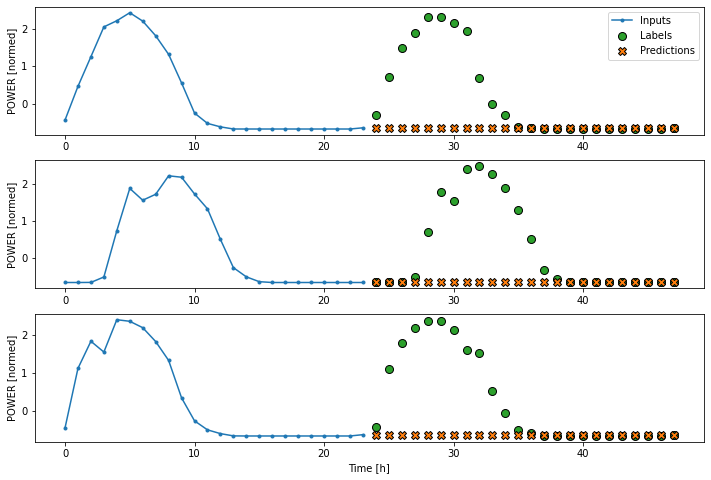

In [37]:
w1.plot(last_baseline)

### 4.1.2 Repeat Baseline

In [38]:
class RepeatBaseline(tf.keras.Model):
    def call(self, inputs):
        return inputs

In [40]:
repeat_baseline = RepeatBaseline()

repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance1["Repeat"] = repeat_baseline.evaluate(w1.val)
performance1["Repeat"] = repeat_baseline.evaluate(w1.test, verbose=0)

val_performance2["Repeat"] = repeat_baseline.evaluate(w2.val)
performance2["Repeat"] = repeat_baseline.evaluate(w2.test, verbose=0)

val_performance3["Repeat"] = repeat_baseline.evaluate(w3.val)
performance3["Repeat"] = repeat_baseline.evaluate(w3.test, verbose=0)

67/67 [==============================] - 0s 4ms/step - loss: 0.5889 - mean_absolute_error: 0.3642


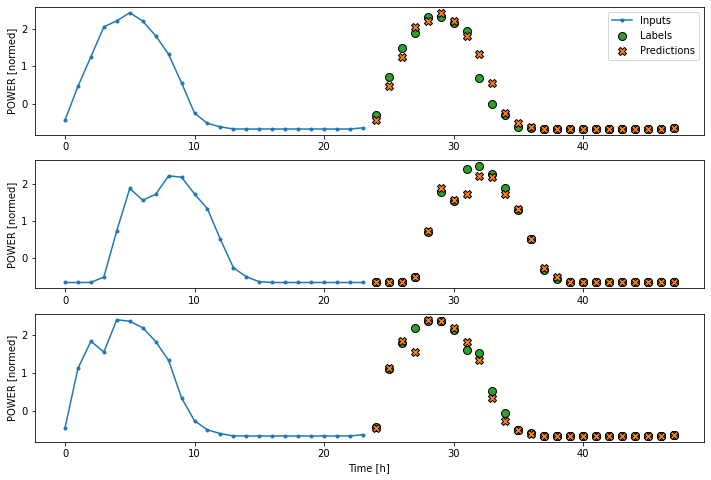

In [41]:
w1.plot(repeat_baseline)

## 4.2 Linear Model

In [42]:
def linear():
    model = tf.keras.Sequential([
        # Take the last time-step
        # Shape [batch, time, features] => [batch, 1, features]
        tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
        # Shape => [batch, 1, out_steps*features]
        tf.keras.layers.Dense(OUT_STEPS*num_features,
                              kernel_initializer=tf.initializers.zeros()),
        # Shape => [batch, out_steps, features]
        tf.keras.layers.Reshape([OUT_STEPS, num_features])
    ])
    return model

In [50]:
linear1 = linear()
compile_and_fit(linear1, w1)
IPython.display.clear_output()
val_performance1["Linear"] = linear1.evaluate(w1.val)
performance1["Linear"] = linear1.evaluate(w1.test, verbose=0)

67/67 [==============================] - 0s 5ms/step - loss: 0.3355 - mean_absolute_error: 0.3186


In [51]:
linear2 = linear()
compile_and_fit(linear2, w2)
IPython.display.clear_output()
val_performance2["Linear"] = linear2.evaluate(w2.val)
performance2["Linear"] = linear2.evaluate(w2.test, verbose=0)

67/67 [==============================] - 0s 4ms/step - loss: 0.3145 - mean_absolute_error: 0.3164


In [52]:
linear3 = linear()
compile_and_fit(linear3, w3)
IPython.display.clear_output()
val_performance3["Linear"] = linear3.evaluate(w3.val)
performance3["Linear"] = linear3.evaluate(w3.test, verbose=0)

67/67 [==============================] - 0s 4ms/step - loss: 0.2930 - mean_absolute_error: 0.3098


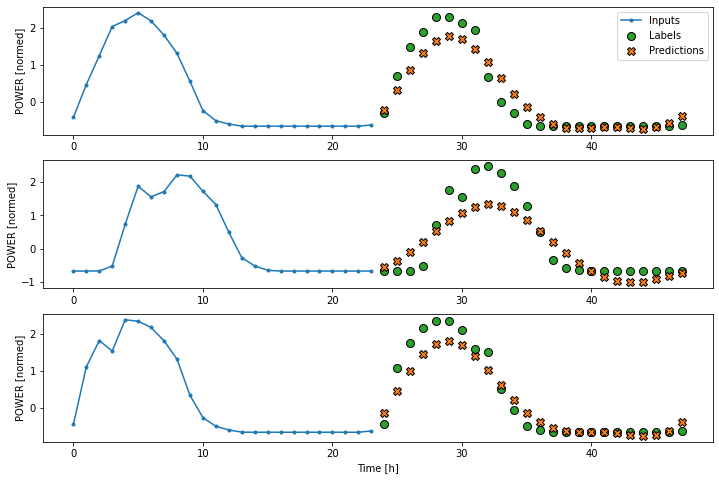

In [53]:
w1.plot(linear1)

## 4.3 Dense Model

In [48]:
def dense():
    model = tf.keras.Sequential([
        # Take the last time step.
        # Shape [batch, time, features] => [batch, 1, features]
        tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
        # Shape => [batch, 1, dense_units]
        tf.keras.layers.Dense(512, activation='relu'),
        # Shape => [batch, out_steps*features]
        tf.keras.layers.Dense(OUT_STEPS*num_features,
                              kernel_initializer=tf.initializers.zeros()),
        # Shape => [batch, out_steps, features]
        tf.keras.layers.Reshape([OUT_STEPS, num_features])
    ])
    return model

In [49]:
dense1 = dense()
compile_and_fit(dense1, w1)
IPython.display.clear_output()
val_performance1["Dense"] = dense1.evaluate(w1.val)
performance1["Dense"] = dense1.evaluate(w1.test, verbose=0)

67/67 [==============================] - 0s 5ms/step - loss: 0.3050 - mean_absolute_error: 0.2890


In [54]:
dense2 = dense()
compile_and_fit(dense2, w2)
IPython.display.clear_output()
val_performance2["Dense"] = dense2.evaluate(w2.val)
performance2["Dense"] = dense2.evaluate(w2.test, verbose=0)

67/67 [==============================] - 1s 6ms/step - loss: 0.2835 - mean_absolute_error: 0.2825


In [55]:
dense3 = dense()
compile_and_fit(dense3, w3)
IPython.display.clear_output()
val_performance3["Dense"] = dense3.evaluate(w3.val)
performance3["Dense"] = dense3.evaluate(w3.test, verbose=0)

67/67 [==============================] - 0s 5ms/step - loss: 0.2575 - mean_absolute_error: 0.2784


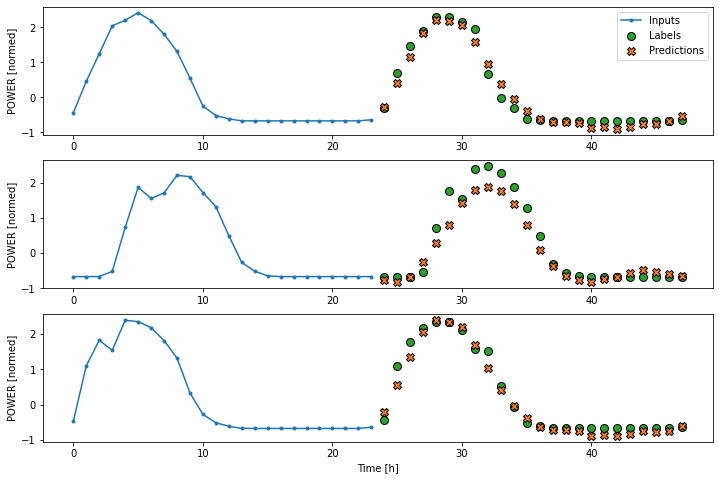

In [56]:
w1.plot(dense1)

## 4.4 CNN

In [57]:
CONV_WIDTH = 3
def cnn():
    model = tf.keras.Sequential([
        # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
        tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
        # Shape => [batch, 1, conv_units]
        tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
        # Shape => [batch, 1,  out_steps*features]
        tf.keras.layers.Dense(OUT_STEPS*num_features,
                            kernel_initializer=tf.initializers.zeros()),
        # Shape => [batch, out_steps, features]
        tf.keras.layers.Reshape([OUT_STEPS, num_features])
    ])
    return model

In [58]:
cnn1 = cnn()
compile_and_fit(cnn1, w1)
IPython.display.clear_output()
val_performance1["Conv"] = cnn1.evaluate(w1.val)
performance1["Conv"] = cnn1.evaluate(w1.test, verbose=0)

67/67 [==============================] - 0s 5ms/step - loss: 0.3073 - mean_absolute_error: 0.2968


In [59]:
cnn2 = cnn()
compile_and_fit(cnn2, w2)
IPython.display.clear_output()
val_performance2["Conv"] = cnn2.evaluate(w2.val)
performance2["Conv"] = cnn2.evaluate(w2.test, verbose=0)

67/67 [==============================] - 1s 6ms/step - loss: 0.2843 - mean_absolute_error: 0.2919


In [60]:
cnn3 = cnn()
compile_and_fit(cnn3, w3)
IPython.display.clear_output()
val_performance3["Conv"] = cnn3.evaluate(w3.val)
performance3["Conv"] = cnn3.evaluate(w3.test, verbose=0)

67/67 [==============================] - 0s 4ms/step - loss: 0.2638 - mean_absolute_error: 0.2861


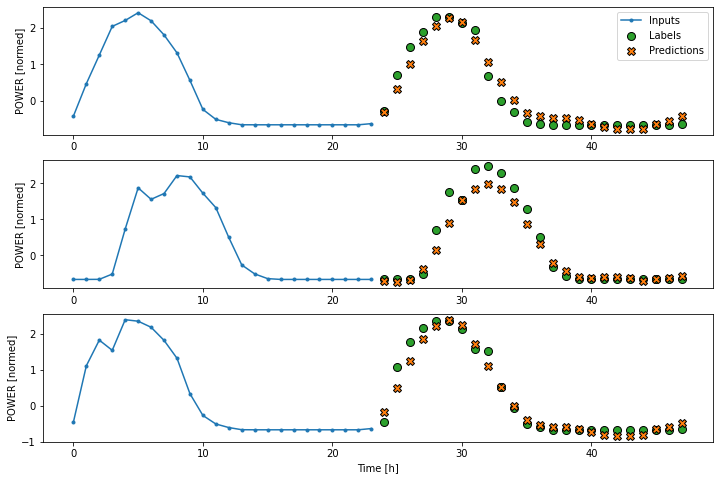

In [61]:
w1.plot(cnn1)

## 4.5 RNN (LSTM)

In [67]:
def lstm():
    model = tf.keras.Sequential([
        # Shape [batch, time, features] => [batch, lstm_units].
        # Adding more `lstm_units` just overfits more quickly.
        tf.keras.layers.LSTM(32, return_sequences=False),
        # Shape => [batch, out_steps*features].
        tf.keras.layers.Dense(OUT_STEPS*num_features,
                            kernel_initializer=tf.initializers.zeros()),
        # Shape => [batch, out_steps, features].
        tf.keras.layers.Reshape([OUT_STEPS, num_features])
    ])
    return model

In [68]:
lstm1 = lstm()
compile_and_fit(lstm1, w1)
IPython.display.clear_output()
val_performance1["LSTM"] = lstm1.evaluate(w1.val)
performance1["LSTM"] = lstm1.evaluate(w1.test, verbose=0)

67/67 [==============================] - 0s 6ms/step - loss: 0.3742 - mean_absolute_error: 0.3567


In [69]:
lstm2 = lstm()
compile_and_fit(lstm2, w2)
IPython.display.clear_output()
val_performance2["LSTM"] = lstm2.evaluate(w2.val)
performance2["LSTM"] = lstm2.evaluate(w2.test, verbose=0)

67/67 [==============================] - 0s 6ms/step - loss: 0.3519 - mean_absolute_error: 0.3578


In [70]:
lstm3 = lstm()
compile_and_fit(lstm3, w3)
IPython.display.clear_output()
val_performance3["LSTM"] = lstm3.evaluate(w3.val)
performance3["LSTM"] = lstm3.evaluate(w3.test, verbose=0)

67/67 [==============================] - 0s 6ms/step - loss: 0.3330 - mean_absolute_error: 0.3590


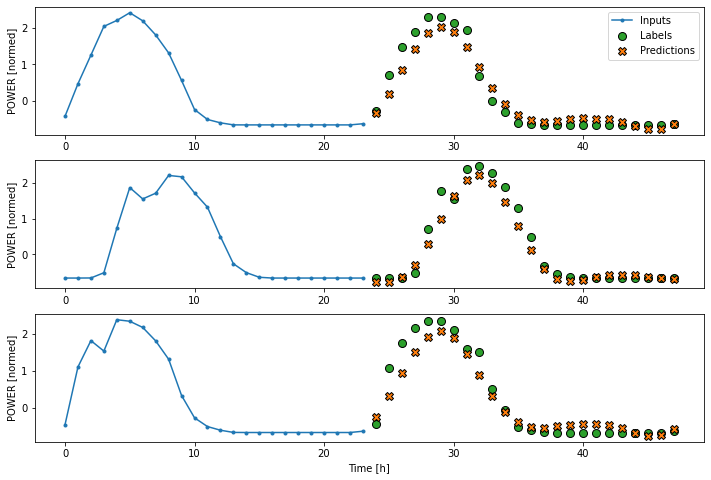

In [73]:
w1.plot(lstm1)

## 4.6 RNN (FeedBack/AR LSTM)

In [74]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify `warmup` method
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)
    
    def warmup(self, inputs):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state = self.lstm_rnn(inputs)

        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state
    
    def call(self, inputs, training=None):
        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []
        # Initialize the LSTM state.
        prediction, state = self.warmup(inputs)

        # Insert the first prediction.
        predictions.append(prediction)

        # Run the rest of the prediction steps.
        for n in range(1, self.out_steps):
            # Use the last prediction as input.
            x = prediction
            # Execute one lstm step.
            x, state = self.lstm_cell(x, states=state,
                                        training=training)
            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            # Add the prediction to the output.
            predictions.append(prediction)

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions

In [75]:
feedback1 = FeedBack(units=32, out_steps=OUT_STEPS)
compile_and_fit(feedback1, w1)
IPython.display.clear_output()
val_performance1["AR LSTM"] = feedback1.evaluate(w1.val)
performance1["AR LSTM"] = feedback1.evaluate(w1.test, verbose=0)

67/67 [==============================] - 1s 7ms/step - loss: 0.3829 - mean_absolute_error: 0.3441


In [76]:
feedback2 = FeedBack(units=32, out_steps=OUT_STEPS)
compile_and_fit(feedback2, w2)
IPython.display.clear_output()
val_performance2["AR LSTM"] = feedback2.evaluate(w2.val)
performance2["AR LSTM"] = feedback2.evaluate(w2.test, verbose=0)

67/67 [==============================] - 1s 7ms/step - loss: 0.3352 - mean_absolute_error: 0.3432


In [77]:
feedback3 = FeedBack(units=32, out_steps=OUT_STEPS)
compile_and_fit(feedback3, w3)
IPython.display.clear_output()
val_performance3["AR LSTM"] = feedback3.evaluate(w3.val)
performance3["AR LSTM"] = feedback3.evaluate(w3.test, verbose=0)

67/67 [==============================] - 1s 7ms/step - loss: 0.3332 - mean_absolute_error: 0.3475


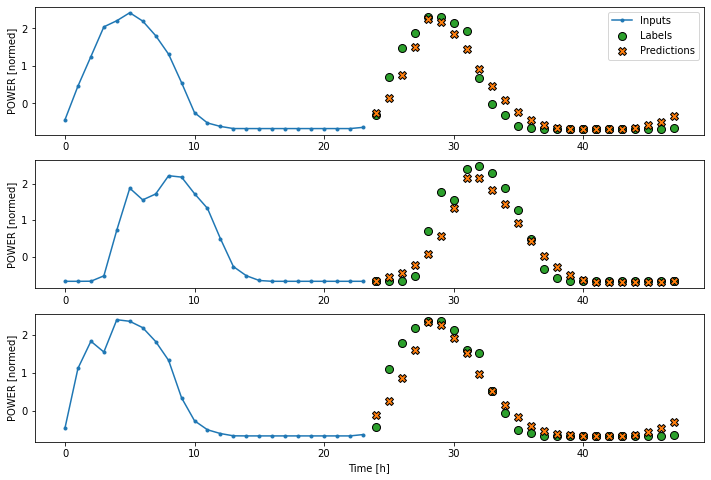

In [78]:
w1.plot(feedback1)

# 5 Results

In [79]:
print(performance1)
print(performance2)
print(performance3)

{'Last': [1.0954501628875732, 0.6307553052902222], 'Repeat': [0.6534520387649536, 0.3744572699069977], 'Linear': [0.3665630519390106, 0.3362375795841217], 'Dense': [0.31930869817733765, 0.29946568608283997], 'Conv': [0.3266238570213318, 0.3078916370868683], 'LSTM': [0.38039711117744446, 0.3594520390033722], 'AR LSTM': [0.399675190448761, 0.3666742742061615]}
{'Last': [1.135372281074524, 0.6396002173423767], 'Repeat': [0.6844804883003235, 0.37699398398399353], 'Linear': [0.38588953018188477, 0.3414064943790436], 'Dense': [0.3413428068161011, 0.3062939941883087], 'Conv': [0.3425927460193634, 0.3112943768501282], 'LSTM': [0.4071124494075775, 0.36987796425819397], 'AR LSTM': [0.39811021089553833, 0.35590553283691406]}
{'Last': [1.122223138809204, 0.6370528936386108], 'Repeat': [0.6845481991767883, 0.3824347257614136], 'Linear': [0.3827567398548126, 0.34048962593078613], 'Dense': [0.33895593881607056, 0.3051817715167999], 'Conv': [0.3402993679046631, 0.31185948848724365], 'LSTM': [0.4068267

In [109]:
x = np.arange(len(performance1))
width = 0.3
metric_names = lstm1.metrics_names
mse_index = metric_names.index("loss")
mae_index = metric_names.index("mean_absolute_error")
header = f"{'Model':8s}| {'MSE':6s} | {'MAE':6s}\n{'-'*8}+{'-'*8}+{'-'*7}"

Model   | MSE    | MAE   
--------+--------+-------
Last    | 1.0955 | 0.6308
Repeat  | 0.6535 | 0.3745
Linear  | 0.3666 | 0.3362
Dense   | 0.3193 | 0.2995
Conv    | 0.3266 | 0.3079
LSTM    | 0.3804 | 0.3595
AR LSTM | 0.3997 | 0.3667


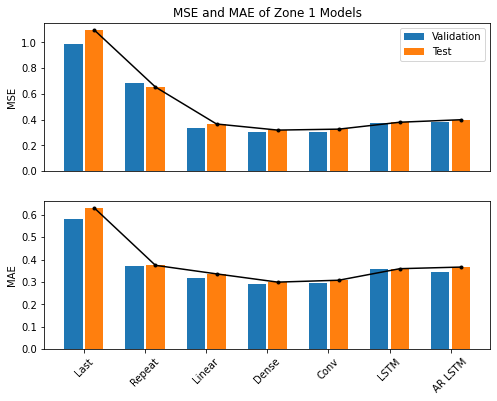

In [126]:
val_mse = [v[mse_index] for v in val_performance1.values()]
test_mse = [v[mse_index] for v in performance1.values()]

val_mae = [v[mae_index] for v in val_performance1.values()]
test_mae = [v[mae_index] for v in performance1.values()]

plt.subplot(2, 1, 1)
plt.title("MSE and MAE of Zone 1 Models")
plt.xticks([], [])
plt.ylabel("MSE")
plt.bar(x - 0.17, val_mse, width, label="Validation")
plt.bar(x + 0.17, test_mse, width, label="Test")
plt.legend()
plt.plot(x + 0.17, test_mse, "k.-")

plt.subplot(2, 1, 2)
plt.ylabel("MAE")
plt.bar(x - 0.17, val_mae, width, label="Validation")
plt.bar(x + 0.17, test_mae, width, label="Test")
plt.xticks(ticks=x, labels=performance1.keys(),
           rotation=45)
plt.plot(x + 0.17, test_mae, "k.-")

print(header)
for name, value in performance1.items():
    print(f"{name:8s}| {value[mse_index]:0.4f} | {value[mae_index]:0.4f}")

Model   | MSE    | MAE   
--------+--------+-------
Last    | 1.1354 | 0.6396
Repeat  | 0.6845 | 0.3770
Linear  | 0.3859 | 0.3414
Dense   | 0.3413 | 0.3063
Conv    | 0.3426 | 0.3113
LSTM    | 0.4071 | 0.3699
AR LSTM | 0.3981 | 0.3559


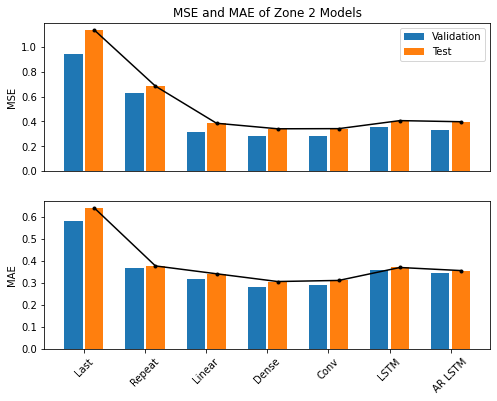

In [125]:
val_mse = [v[mse_index] for v in val_performance2.values()]
test_mse = [v[mse_index] for v in performance2.values()]

val_mae = [v[mae_index] for v in val_performance2.values()]
test_mae = [v[mae_index] for v in performance2.values()]

plt.subplot(2, 1, 1)
plt.title("MSE and MAE of Zone 2 Models")
plt.xticks([], [])
plt.ylabel("MSE")
plt.bar(x - 0.17, val_mse, width, label="Validation")
plt.bar(x + 0.17, test_mse, width, label="Test")
plt.legend()
plt.plot(x + 0.17, test_mse, "k.-")

plt.subplot(2, 1, 2)
plt.ylabel("MAE")
plt.bar(x - 0.17, val_mae, width, label="Validation")
plt.bar(x + 0.17, test_mae, width, label="Test")
plt.xticks(ticks=x, labels=performance2.keys(),
           rotation=45)
plt.plot(x + 0.17, test_mae, "k.-")

print(header)
for name, value in performance2.items():
    print(f"{name:8s}| {value[mse_index]:0.4f} | {value[mae_index]:0.4f}")

Model   | MSE    | MAE   
--------+--------+-------
Last    | 1.1222 | 0.6371
Repeat  | 0.6845 | 0.3824
Linear  | 0.3828 | 0.3405
Dense   | 0.3390 | 0.3052
Conv    | 0.3403 | 0.3119
LSTM    | 0.4068 | 0.3722
AR LSTM | 0.4115 | 0.3695


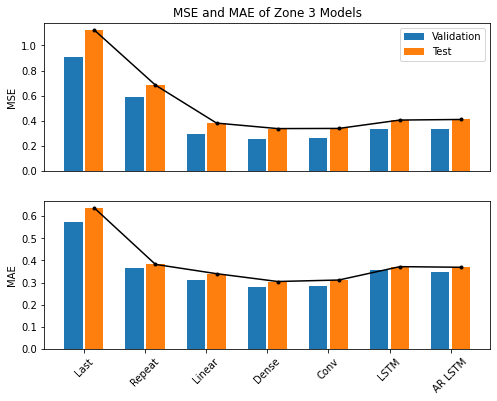

In [121]:
val_mse = [v[mse_index] for v in val_performance3.values()]
test_mse = [v[mse_index] for v in performance3.values()]

val_mae = [v[mae_index] for v in val_performance3.values()]
test_mae = [v[mae_index] for v in performance3.values()]

plt.subplot(2, 1, 1)
plt.title("MSE and MAE of Zone 3 Models")
plt.xticks([], [])
plt.ylabel("MSE")
plt.bar(x - 0.17, val_mse, width, label="Validation")
plt.bar(x + 0.17, test_mse, width, label="Test")
plt.legend()
plt.plot(x + 0.17, test_mse, "k.-")

plt.subplot(2, 1, 2)
plt.ylabel("MAE")
plt.bar(x - 0.17, val_mae, width, label="Validation")
plt.bar(x + 0.17, test_mae, width, label="Test")
plt.xticks(ticks=x, labels=performance3.keys(),
           rotation=45)
plt.plot(x + 0.17, test_mae, "k.-")

print(header)
for name, value in performance3.items():
    print(f"{name:8s}| {value[mse_index]:0.4f} | {value[mae_index]:0.4f}")